# Clustering based Recommender

Why clustering instead of user-based filtering or item-based recommendation?
- avoid cold start problem (when user did not provide implicit feedback such as ratings etc

Reference:
- https://towardsdatascience.com/build-your-own-clustering-based-recommendation-engine-in-15-minutes-bdddd591d394

In [1]:
import numpy as np
import pandas as pd

In [2]:
course_df = pd.read_csv("data/courses.csv")
course_df.head()

,CourseId,CourseTitle,DurationInSeconds,ReleaseDate,Description,AssessmentStatus,IsCourseRetired
0,abts-advanced-topics,BizTalk 2006 Business Process Management,22198,2008-10-25,This course covers Business Process Management...,Live,no
1,abts-fundamentals,BizTalk 2006 Fundamentals,24305,2008-06-01,Despite the trend towards service-oriented arc...,Live,no
2,agile-team-practice-fundamentals,Agile Team Practices with Scrum,13504,2010-04-15,This course is much different than most of the...,Live,no
3,appsrv-fundamentals,Windows Server AppFabric Fundamentals,0,2000-01-01,NaN,None,yes
4,aspdotnet-advanced-topics,ASP.NET 3.5 Advanced Topics,21611,2008-12-05,This course covers more advanced topics in ASP...,Live,no


In [3]:
course_df.isnull().sum()

CourseId             0
CourseTitle          0
DurationInSeconds    0
ReleaseDate          0
Description          5
AssessmentStatus     0
IsCourseRetired      0
dtype: int64

In [4]:
# Drop rows with NaN values, specifically description.
course_df.dropna(how="any", inplace=True)
course_df.isnull().sum().sum()

0

In [5]:
# Preprocessing step


def preprocess(description):
    return description.replace("'ll", "").replace("-", "")

In [6]:
course_df.Description = course_df.Description.apply(preprocess)
course_df.head()

,CourseId,CourseTitle,DurationInSeconds,ReleaseDate,Description,AssessmentStatus,IsCourseRetired
0,abts-advanced-topics,BizTalk 2006 Business Process Management,22198,2008-10-25,This course covers Business Process Management...,Live,no
1,abts-fundamentals,BizTalk 2006 Fundamentals,24305,2008-06-01,Despite the trend towards serviceoriented arch...,Live,no
2,agile-team-practice-fundamentals,Agile Team Practices with Scrum,13504,2010-04-15,This course is much different than most of the...,Live,no
4,aspdotnet-advanced-topics,ASP.NET 3.5 Advanced Topics,21611,2008-12-05,This course covers more advanced topics in ASP...,Live,no
5,aspdotnet-ajax-advanced-topics,ASP.NET Ajax Advanced Topics,10426,2008-09-30,This course covers advanced topics in ASP.NET ...,Live,no


In [7]:
def merge_columns(df):
    return df["CourseId"] + " " + df["CourseTitle"] + " " + df["Description"]


course_df["combined"] = course_df.apply(merge_columns, axis=1)
course_df.head()

,CourseId,CourseTitle,DurationInSeconds,ReleaseDate,Description,AssessmentStatus,IsCourseRetired,combined
0,abts-advanced-topics,BizTalk 2006 Business Process Management,22198,2008-10-25,This course covers Business Process Management...,Live,no,abts-advanced-topics BizTalk 2006 Business Pro...
1,abts-fundamentals,BizTalk 2006 Fundamentals,24305,2008-06-01,Despite the trend towards serviceoriented arch...,Live,no,abts-fundamentals BizTalk 2006 Fundamentals De...
2,agile-team-practice-fundamentals,Agile Team Practices with Scrum,13504,2010-04-15,This course is much different than most of the...,Live,no,agile-team-practice-fundamentals Agile Team Pr...
4,aspdotnet-advanced-topics,ASP.NET 3.5 Advanced Topics,21611,2008-12-05,This course covers more advanced topics in ASP...,Live,no,aspdotnet-advanced-topics ASP.NET 3.5 Advanced...
5,aspdotnet-ajax-advanced-topics,ASP.NET Ajax Advanced Topics,10426,2008-09-30,This course covers advanced topics in ASP.NET ...,Live,no,aspdotnet-ajax-advanced-topics ASP.NET Ajax Ad...


In [8]:
# Remove all characters except numbers and alphabets. Numbers are retained because they are specific to specific course series.
course_df["combined"] = course_df["combined"].replace(
    {"[^A-Za-z-09 ]+": ""}, regex=True
)
course_df.head()

,CourseId,CourseTitle,DurationInSeconds,ReleaseDate,Description,AssessmentStatus,IsCourseRetired,combined
0,abts-advanced-topics,BizTalk 2006 Business Process Management,22198,2008-10-25,This course covers Business Process Management...,Live,no,abts-advanced-topics BizTalk 00 Business Proce...
1,abts-fundamentals,BizTalk 2006 Fundamentals,24305,2008-06-01,Despite the trend towards serviceoriented arch...,Live,no,abts-fundamentals BizTalk 00 Fundamentals Desp...
2,agile-team-practice-fundamentals,Agile Team Practices with Scrum,13504,2010-04-15,This course is much different than most of the...,Live,no,agile-team-practice-fundamentals Agile Team Pr...
4,aspdotnet-advanced-topics,ASP.NET 3.5 Advanced Topics,21611,2008-12-05,This course covers more advanced topics in ASP...,Live,no,aspdotnet-advanced-topics ASPNET Advanced Top...
5,aspdotnet-ajax-advanced-topics,ASP.NET Ajax Advanced Topics,10426,2008-09-30,This course covers advanced topics in ASP.NET ...,Live,no,aspdotnet-ajax-advanced-topics ASPNET Ajax Adv...


In [65]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", lowercase=True)
X = vectorizer.fit_transform(course_df["combined"])

In [110]:
inertias = []

# Running with 0 clusters lead to the error "cannot convert float infinity to integer"
for k in range(3, 10):
    model = KMeans(n_clusters=k, init="k-means++", max_iter=500, n_init=15)
    model.fit(X)

    inertias.append(model.inertia_)

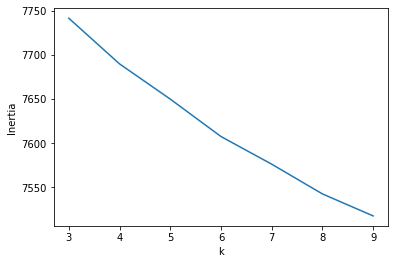

In [111]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(range(3, 10), inertias)
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

In [106]:
# True k, derived from elbow method and confirmed from pluralsight's website
# true_k = 8
true_k = 30

model = KMeans(n_clusters=true_k, init="k-means++", max_iter=500, n_init=15)
model.fit(X)

KMeans(max_iter=500, n_clusters=30, n_init=15)

In [95]:
# Top terms in each cluster.

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]  # Reverse order
terms = vectorizer.get_feature_names()

for i in range(true_k):
    print("Cluster {}:".format(i + 1))
    for ind in order_centroids[i, :15]:
        print(" ", terms[ind])
    print()

Top terms per cluster:
Cluster 1:
  mari
  textures
  painting
  texturing
  texture
  paint
  ptex
  map
  tutorial
  learn
  maps
  workflow
  color
  new
  assets

Cluster 2:
  security
  comptia
  network
  information
  awareness
  course
  cyber
  attacks
  threats
  secure
  plus
  cissp
  learn
  risks
  certification

Cluster 3:
  web
  android
  html
  css
  app
  javascript
  applications
  apps
  application
  course
  mobile
  responsive
  building
  build
  learn

Cluster 4:
  tricks
  tips
  softimage
  centering
  ice
  selfcontained
  nodes
  video
  lesson
  improve
  workflows
  various
  maya
  rendering
  help

Cluster 5:
  max
  ds
  modeling
  animation
  create
  techniques
  required
  learn
  creating
  software
  start
  tools
  rigging
  rendering
  tutorial

Cluster 6:
  studio
  visual
  code
  team
  tfs
  debugging
  course
  tools
  net
  features
  android
  developers
  00
  new
  lightswitch

Cluster 7:
  office
  linux
  course
  lpic
  centos
  adm

In [96]:
def cluster_predict(str_input):
    y = vectorizer.transform([str_input])
    preds = model.predict(y)
    return preds[0]

In [97]:
# Apply the clustering to exising cluster.
course_df["ClusterPrediction"] = course_df.apply(
    lambda x: cluster_predict(x.combined), axis=1
)
course_df.head()

,CourseId,CourseTitle,DurationInSeconds,ReleaseDate,Description,AssessmentStatus,IsCourseRetired,combined,ClusterPrediction
0,abts-advanced-topics,BizTalk 2006 Business Process Management,22198,2008-10-25,This course covers Business Process Management...,Live,no,abts-advanced-topics BizTalk 00 Business Proce...,24
1,abts-fundamentals,BizTalk 2006 Fundamentals,24305,2008-06-01,Despite the trend towards serviceoriented arch...,Live,no,abts-fundamentals BizTalk 00 Fundamentals Desp...,24
2,agile-team-practice-fundamentals,Agile Team Practices with Scrum,13504,2010-04-15,This course is much different than most of the...,Live,no,agile-team-practice-fundamentals Agile Team Pr...,18
4,aspdotnet-advanced-topics,ASP.NET 3.5 Advanced Topics,21611,2008-12-05,This course covers more advanced topics in ASP...,Live,no,aspdotnet-advanced-topics ASPNET Advanced Top...,22
5,aspdotnet-ajax-advanced-topics,ASP.NET Ajax Advanced Topics,10426,2008-09-30,This course covers advanced topics in ASP.NET ...,Live,no,aspdotnet-ajax-advanced-topics ASPNET Ajax Adv...,22


In [98]:
def recommend_util(str_input):
    cluster = cluster_predict(str_input.lower())
    print(cluster)
    return course_df[course_df["ClusterPrediction"] == cluster].head(10)

In [101]:
recommend_util("aspdotnet")

24


,CourseId,CourseTitle,DurationInSeconds,ReleaseDate,Description,AssessmentStatus,IsCourseRetired,combined,ClusterPrediction
0,abts-advanced-topics,BizTalk 2006 Business Process Management,22198,2008-10-25,This course covers Business Process Management...,Live,no,abts-advanced-topics BizTalk 00 Business Proce...,24
1,abts-fundamentals,BizTalk 2006 Fundamentals,24305,2008-06-01,Despite the trend towards serviceoriented arch...,Live,no,abts-fundamentals BizTalk 00 Fundamentals Desp...,24
14,aspdotnet-undo,Implementing Undo in ASP.NET WebForms and MVC,4765,2010-08-27,There's loads of advice out there recommending...,Live,no,aspdotnet-undo Implementing Undo in ASPNET Web...,24
17,bts09-custom-ms,Advanced BizTalk Server 2009,43411,2010-04-06,This course provides detailed investigation in...,None,no,bts09-custom-ms Advanced BizTalk Server 009 Th...,24
18,bts09-fundamentals,BizTalk 2009 Fundamentals,13929,2009-11-24,Despite the trend towards serviceoriented arch...,Live,no,bts09-fundamentals BizTalk 009 Fundamentals De...,24
20,clojure-concurrency-tutorial,Clojure Concurrency,9261,2010-04-09,Clojure is a new Lisp that runs on the JVM and...,Live,yes,clojure-concurrency-tutorial Clojure Concurren...,24
21,clr-fundamentals,CLR Fundamentals,15647,2010-04-13,At the heart of the .NET Framework is an execu...,Live,no,clr-fundamentals CLR Fundamentals At the heart...,24
22,clr-threading,CLR Threading,9451,2010-04-13,This course presents the threading features of...,Live,no,clr-threading CLR Threading This course presen...,24
23,csharp-fundamentals,Accelerated C# Fundamentals,22628,2010-03-26,C# is Microsoft's entry into the world of mana...,Live,no,csharp-fundamentals Accelerated C Fundamentals...,24
25,dotnet-distributed-architecture,.NET Distributed Systems Architecture,19824,2010-07-06,This course provides an overview of the archit...,Live,no,dotnet-distributed-architecture NET Distribute...,24


In [104]:
recommend_util("qa testing")

17


,CourseId,CourseTitle,DurationInSeconds,ReleaseDate,Description,AssessmentStatus,IsCourseRetired,combined,ClusterPrediction
78,test-first-development-1,Test First Development - Part 1,12825,2010-11-16,This course introduces a testfirst development...,Live,no,test-first-development- Test First Development...,17
118,test-first-development-2,Test First Development - Part 2,9868,2011-02-21,This course continues the subject of Test Firs...,Live,no,test-first-development- Test First Development...,17
130,mstest,Unit Testing with MSTest,11067,2011-04-25,In this course you will be learning about usin...,Live,yes,mstest Unit Testing with MSTest In this course...,17
278,rhinomock-fundamentals,Rhino Mocks Fundamentals,7942,2012-06-28,In this course you will learn how to use Rhino...,Live,no,rhinomock-fundamentals Rhino Mocks Fundamental...,17
311,selenium,Automated Web Testing with Selenium,12110,2012-09-10,Creating automated tests for a web application...,Live,no,selenium Automated Web Testing with Selenium C...,17
350,alm-for-developers,ALM for Developers with Visual Studio 2012,16264,2012-09-24,This course covers Microsoft's Application Lif...,Live,no,alm-for-developers ALM for Developers with Vis...,17
357,teststudio-fund,Test Studio Fundamentals,6475,2012-10-02,This course is an introduction to the fundamen...,Live,no,teststudio-fund Test Studio Fundamentals This ...,17
358,microsoft-fakes,Microsoft Fakes Fundamentals,6988,2012-10-10,In this course you will learn how to use the M...,Live,no,microsoft-fakes Microsoft Fakes Fundamentals I...,17
414,testable-windows-8,Testable Windows 8 Applications,10848,2013-01-28,This course explores the ins and outs of devel...,Live,no,testable-windows- Testable Windows Applicatio...,17
420,testing-javascript,Testing Clientside JavaScript,17435,2013-02-12,Javascript is the programming language of the ...,Live,no,testing-javascript Testing Clientside JavaScri...,17


In [100]:
np.unique(course_df["ClusterPrediction"], return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([  50,  185,  424,  109,  232,   71,  102,  313,  211,  377,  205,
         156,   50,  111,  125,  137,  253,  140,  132,  149,  177,  282,
         167,  310, 2561,  179,  139,  100,  104,  460]))

In [175]:
# DBSCAN works poorly for text similarity ...
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=1e-20, min_samples=3)
model.fit(X)
np.unique(model.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16]),
 array([7954,    3,    4,    3,    3,    4,    3,    3,    5,    3,    4,
           4,    3,    3,    3,    3,    3,    3]))

In [201]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 30
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda.fit(X)

LatentDirichletAllocation(n_components=30, random_state=0)

In [211]:
def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(
            " ".join(
                [feature_names[i] for i in topic.argsort()[: -n_top_words - 1 : -1]]
            )
        )
        print()

In [212]:
print_top_words(lda, vectorizer.get_feature_names())

Topic #0:
sketchup lip ptex structural interiors steady anticipation nservicebus patterns easytofollow

Topic #1:
microservices sap ee abap vuejs github ml durandal downloads cloudwatch

Topic #2:
infiltrator desgn ccda casp cas corel civil mantra backburner regions

Topic #3:
maya modeling character ds max animation rigging create tools learn

Topic #4:
motionbuilder cryengine gamesalad outsourcing mech silo civil payments graphite hybrido

Topic #5:
tensorflow fabric wireless ef neural regression vrealize hdri icnd router

Topic #6:
hacking ethical powerpivot accredited eccouncil partner official phonegap caricatures caricature

Topic #7:
akkanet qt storyboard injection artrage patterns actors symmetry concurrent actor

Topic #8:
laravel pmp warehousing swarm syntheyes destruction json ghost analytical tailoring

Topic #9:
cryptography django muse ansible jenkins xenserver phone mercurial grasshopper wmi

Topic #10:
web aws aspnet applications api core nodejs data java application

T

In [204]:
lda.transform(vectorizer.transform(["testing"])).argmax()

18

In [205]:
def cluster_predict(str_input):
    X = vectorizer.transform([str_input])
    topic = lda.transform(X).argmax()
    return topic

In [206]:
# Apply the clustering to exising cluster.
course_df["ClusterPrediction"] = course_df.apply(
    lambda x: cluster_predict(x.combined), axis=1
)
course_df.head()

,CourseId,CourseTitle,DurationInSeconds,ReleaseDate,Description,AssessmentStatus,IsCourseRetired,combined,ClusterPrediction
0,abts-advanced-topics,BizTalk 2006 Business Process Management,22198,2008-10-25,This course covers Business Process Management...,Live,no,abts-advanced-topics BizTalk 00 Business Proce...,12
1,abts-fundamentals,BizTalk 2006 Fundamentals,24305,2008-06-01,Despite the trend towards serviceoriented arch...,Live,no,abts-fundamentals BizTalk 00 Fundamentals Desp...,12
2,agile-team-practice-fundamentals,Agile Team Practices with Scrum,13504,2010-04-15,This course is much different than most of the...,Live,no,agile-team-practice-fundamentals Agile Team Pr...,11
4,aspdotnet-advanced-topics,ASP.NET 3.5 Advanced Topics,21611,2008-12-05,This course covers more advanced topics in ASP...,Live,no,aspdotnet-advanced-topics ASPNET Advanced Top...,10
5,aspdotnet-ajax-advanced-topics,ASP.NET Ajax Advanced Topics,10426,2008-09-30,This course covers advanced topics in ASP.NET ...,Live,no,aspdotnet-ajax-advanced-topics ASPNET Ajax Adv...,12


In [207]:
np.unique(course_df["ClusterPrediction"], return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([   9,    5,    7, 1089,   13,    9,    5,   14,   10,    7,  264,
        2166, 2190,   31,   33,   41,   12,   11,  194,    8,   13,   22,
         746,    8,    8,    8, 1029,   36,    7,   16]))

In [208]:
recommend_util("machine learning")

12


,CourseId,CourseTitle,DurationInSeconds,ReleaseDate,Description,AssessmentStatus,IsCourseRetired,combined,ClusterPrediction
0,abts-advanced-topics,BizTalk 2006 Business Process Management,22198,2008-10-25,This course covers Business Process Management...,Live,no,abts-advanced-topics BizTalk 00 Business Proce...,12
1,abts-fundamentals,BizTalk 2006 Fundamentals,24305,2008-06-01,Despite the trend towards serviceoriented arch...,Live,no,abts-fundamentals BizTalk 00 Fundamentals Desp...,12
5,aspdotnet-ajax-advanced-topics,ASP.NET Ajax Advanced Topics,10426,2008-09-30,This course covers advanced topics in ASP.NET ...,Live,no,aspdotnet-ajax-advanced-topics ASPNET Ajax Adv...,12
12,aspdotnet-mvc2,ASP.NET MVC 2.0 Fundamentals,6885,2010-08-13,The ASP.NET MVC 2.0 framework adds a number of...,Live,no,aspdotnet-mvc ASPNET MVC 0 Fundamentals The AS...,12
15,azure-fundamentals,Microsoft Azure Fundamentals,17856,2010-03-27,This course introduces you to the new world of...,Live,no,azure-fundamentals Microsoft Azure Fundamental...,12
16,bts09-advanced-topics,BizTalk 2009 Business Process Management,16979,2009-11-24,This course covers Business Process Management...,Live,no,bts09-advanced-topics BizTalk 009 Business Pro...,12
17,bts09-custom-ms,Advanced BizTalk Server 2009,43411,2010-04-06,This course provides detailed investigation in...,None,no,bts09-custom-ms Advanced BizTalk Server 009 Th...,12
18,bts09-fundamentals,BizTalk 2009 Fundamentals,13929,2009-11-24,Despite the trend towards serviceoriented arch...,Live,no,bts09-fundamentals BizTalk 009 Fundamentals De...,12
19,btsr2-fundamentals,BizTalk Server 2006 R2 Fundamentals,21996,2008-08-20,BizTalk Server 2006 is Microsoft's integration...,None,no,btsr-fundamentals BizTalk Server 00 R Fundamen...,12
25,dotnet-distributed-architecture,.NET Distributed Systems Architecture,19824,2010-07-06,This course provides an overview of the archit...,Live,no,dotnet-distributed-architecture NET Distribute...,12


In [210]:
recommend_util("game programming")

11


,CourseId,CourseTitle,DurationInSeconds,ReleaseDate,Description,AssessmentStatus,IsCourseRetired,combined,ClusterPrediction
2,agile-team-practice-fundamentals,Agile Team Practices with Scrum,13504,2010-04-15,This course is much different than most of the...,Live,no,agile-team-practice-fundamentals Agile Team Pr...,11
6,aspdotnet-ajax-fundamentals,ASP.NET Ajax Fundamentals,22296,2008-09-11,ASP.NET Ajax is a Web development framework fo...,Live,no,aspdotnet-ajax-fundamentals ASPNET Ajax Fundam...,11
8,aspdotnet-data,ASP.NET 3.5 Working With Data,27668,2008-12-04,ASP.NET has established itself as one of the m...,Live,no,aspdotnet-data ASPNET Working With Data ASPNE...,11
9,aspdotnet-fundamentals,ASP.NET 3.5 Fundamentals,25160,2008-11-12,ASP.NET has established itself as one of the m...,Live,no,aspdotnet-fundamentals ASPNET Fundamentals AS...,11
21,clr-fundamentals,CLR Fundamentals,15647,2010-04-13,At the heart of the .NET Framework is an execu...,Live,no,clr-fundamentals CLR Fundamentals At the heart...,11
23,csharp-fundamentals,Accelerated C# Fundamentals,22628,2010-03-26,C# is Microsoft's entry into the world of mana...,Live,no,csharp-fundamentals Accelerated C Fundamentals...,11
24,dotnet-csharp-tutorial,Introduction to C# and .NET,13531,2009-07-14,This tutorial is aimed at programmers who are ...,Live,yes,dotnet-csharp-tutorial Introduction to C and N...,11
26,dynamic-data-tutorial,ASP.NET Dynamic Data Fundamentals,18135,2010-06-17,"In this tutorial, we build a simple campaign m...",Live,no,dynamic-data-tutorial ASPNET Dynamic Data Fund...,11
30,iphone-aspdotnet,iPhone ASP.NET Fundamentals,25754,2010-07-01,The iPhone’s rich user interface and platform ...,Live,no,iphone-aspdotnet iPhone ASPNET Fundamentals Th...,11
31,linq-architecture,LINQ Architecture,4997,2010-10-08,This course looks at using LINQ in the busines...,Live,no,linq-architecture LINQ Architecture This cours...,11
